In [1]:
from functools import lru_cache
from sklearn.svm import SVC
import dtreeviz.trees as dtreeviz
import graphviz
import ipywidgets as widgets
import numpy as np
import seaborn as sns
import pandas as pd
from IPython.display import SVG, display
from ipywidgets import Button, IntSlider, interactive
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn import preprocessing, tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from sklearn.model_selection import StratifiedKFold
sns.set()

from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import DBSCAN


In [2]:
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import conversion_numerica
from preprocessing import plot_roc_curves
from preprocessing import graficar_matriz_confusion

# Introducción

https://scikit-learn.org/dev/modules/svm.html

* Algoritmo iterativo.
* Debido a cómo está matemáticamente planteado, el algoritmo converge y no hay óptimos locales. 
    * Podemos decir que llegar a la mejor solucion existente.
* Hay dos parámetros de stop en este algoritmo iterativo:
    * cantidad de iteraciones 
    * delta de mejora entre iteraciones 
* _Hiperparametro **C**_: podemos dejar de tener una linea que divida perfectamente a los puntos, y lograr obtener a un hiperplano que me divida bastante bien, no perfecto, y que pueda safar en un punto de ruido. Entonces el C nos permite jugar un poco. Permitimos porcentaje pequeño de ruido en la solución de éste problema.
* _Kernels_: nos ayuda a cambiar el producto itnerno. Simula estar en una dimension mas alta y lograr encontrar con un hiperplano y ahorrarnos costo computacional con el mismo kernel.
    * Es decir, solo cambiando el producto interno engañamos para multiplicar altas dimensiones.
    * Kernels más comunes:
        * Lineal: $K(a,b)=a.b+r$
            * con $r$ hiperparametro elegible.  
        * Polinomial: $K(a,b)=(a.b+r)^{d}$ 
            * con $r$ y $d$ hiperparametros elegibles.
            * con $d=1$ sería un kernel lineal.
        * Radial Kernel: RBF (Radial Base Function): $K(a,b)=e^{-\alpha(a-b)^{2}}$
            * con $\alpha$ hiperparametro elegible. 
        * Sigmoid: $K(a,b)=tanh(\alpha.a.b+c)$
            * con $\alpha$ y $c$ hiperparametros elegibles. 



    

# Kernels a utilizar

Teniendo en cuenta la biblografia de SVM:
https://scikit-learn.org/stable/modules/svm.html#complexity

El algoritmo puede llegar a ser $O(n_{features} \times n_{samples}^2)$ como $O(n_{features} \times n_{samples}^3)$
$O(n_{features} \times n_{samples}^3)$ lo cual para nuestro dataset a entrenar con casi 30k de instancias puede ser un gran problema. La alta dimensionalidad nos juega una gran pasada.

Aunque según la misma biblografia compartida, nos aclara que el caso lineal de SVM (LinearSVC) es muchisimo mas eficiente y puede escalar con millones de datos más.

Al inicio de este notebook se verá reflejado el trabajo realizado con el LinearSVC y habiendo realizado las predicciones de holdout con LinearSVC pero al final del notebooks mostraremos el trabajo realizado con kernels no linieales y demostrar que la alta dimensionalidad nos juega en contra. 



In [3]:
from preprocessing import get_dataframe_scaled
from preprocessing import get_dataframe_polynomial
from preprocessing import reduccion_numerica


# LinearSVC

In [5]:
from sklearn.svm import LinearSVC

Segun la biblografía de LinearSVC, el mismo es como usar a SVC(kernel='linear') pero que está implementado con la libreria de **liblinear** en vez de **libsvm**. Esto nos permite ser mas flexibles en las seleccion mediante una funcion de perdida y en la penalización de los datos. Es decir, tendremos 2 nuevos hiperparametros a probar:

**(despues describir mejor estos hiperparametros)**
* Penalty
    * l1
    * l2
* Loss:
    * hinge
    * squared_hinge



## Primer preprocesamiento: conversion_numerica() + MinMaxScaler()

Además de la **conversion_numerica()** también aplicaremos un escalado de los datos que es recomendado según la biblografía (https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use).

In [6]:
df, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df) 

Aplicando 'conversion_numerica' en las variables categóricas.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_df_numerico, y_df, test_size=0.20, random_state=10, stratify=y_df)
X_train = get_dataframe_scaled(X_train, MinMaxScaler(feature_range=(-1,1)))
X_test = get_dataframe_scaled(X_test, MinMaxScaler(feature_range=(-1,1)))

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  4.4min finished


[LibLinear]Accuracy sobre test:  0.8455396898510671
Los mejores hiperpametros elegidos:  {'C': 75, 'loss': 'squared_hinge', 'penalty': 'l2'}
              precision    recall  f1-score   support

  Bajo valor       0.94      0.87      0.90      5345
  Alto valor       0.55      0.74      0.63      1168

    accuracy                           0.85      6513
   macro avg       0.75      0.80      0.77      6513
weighted avg       0.87      0.85      0.85      6513



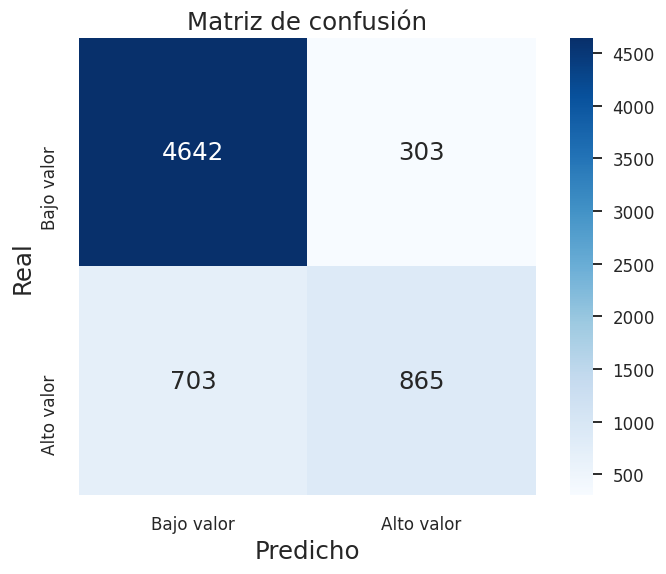

In [8]:
params = [ {'C':np.arange(60,80,1), 'penalty': ['l1', 'l2'], 'loss': ['hinge', 'squared_hinge']}]

clf=LinearSVC( random_state=10,verbose=True, dual=False)
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf = GridSearchCV(clf, 
                   param_grid = params,
                   scoring = 'roc_auc',
                   cv = cv_e,
                   n_jobs = -1,
                   verbose=1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)


Para conseguir la metrica AUC-ROC, sobre LinearSVC() no es posible

In [9]:
# clf.predict_proba(X_test)[:, 1]

Cuando se entrena con el SVC() tampoco es posible a no ser que se le especifique el parametro 'probability=True'.

Segun la biblografía: https://scikit-learn.org/stable/modules/svm.html#scores-and-probabilities
        
        Note: The same probability calibration procedure is available for all estimators via the CalibratedClassifierCV. In the case of SVC and NuSVC, this procedure is builtin in libsvm which is used under the hood, so it does not rely on scikit-learn’s CalibratedClassifierCV.

Por ende utilizaremos 'CalibratedClassifierCV' para predecir la probabilidad de las clases y graficar el AUC-ROC score.
        

AUC-ROC score sobre test:  0.8958852866222323


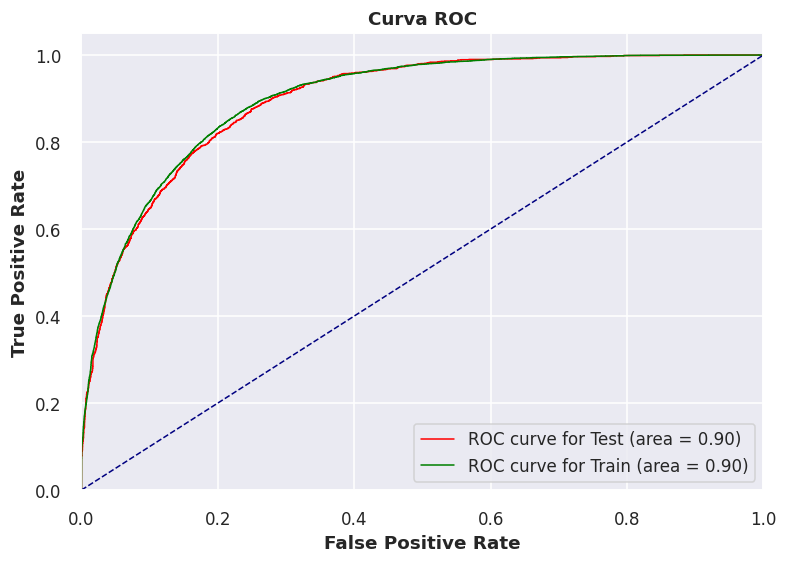

In [10]:
from sklearn.calibration import CalibratedClassifierCV

clf_best=LinearSVC(random_state=10, dual=False, C = 75, loss= 'squared_hinge', penalty='l2')
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf_cal = CalibratedClassifierCV(clf_best,cv=cv_e) 
clf_cal.fit(X_train, y_train)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test,  clf_cal.predict_proba(X_test)[:, 1]))
plot_roc_curves(clf_cal, X_test, y_test, X_train, y_train)

## Segundo preprocesamietno: get_dataframe_polynomial() + reduccion_numerica()

**OJO ESTE PREPROCESAMIENTO SE VISUALIZÓ CON T-SNE ALLÁ EN EL NOTEBOOK #0**

** FALTA CREAR LA FUNCION Y USARLA ACÁ!!!!!!!!!!!!!!!!! **

In [11]:
df, df_for_prediction = obtener_datasets()
X_df_r, y_df_r = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df_r)
X_poly = get_dataframe_polynomial(X_df_numerico, 2, False)

Aplicando 'conversion_numerica' en las variables categóricas.
Dataset inicial con 40 features...
Dataset nuevo con PolynomialFeature con 50 features...


In [12]:
X_poly_red = reduccion_numerica(X_poly, 0.95)

Aplicando MinMaxScaler previo al TruncatedSVD...
TruncatedSVD aplicado con 24 componentes finales se explica una varianza de: 0.9520266151


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 593 out of 600 | elapsed:   40.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   41.1s finished


[LibLinear]Accuracy sobre test:  0.8269614616920006
Los mejores hiperpametros elegidos:  {'C': 1, 'loss': 'squared_hinge', 'penalty': 'l1'}
              precision    recall  f1-score   support

  Bajo valor       0.93      0.86      0.89      5348
  Alto valor       0.51      0.69      0.59      1165

    accuracy                           0.83      6513
   macro avg       0.72      0.77      0.74      6513
weighted avg       0.85      0.83      0.84      6513



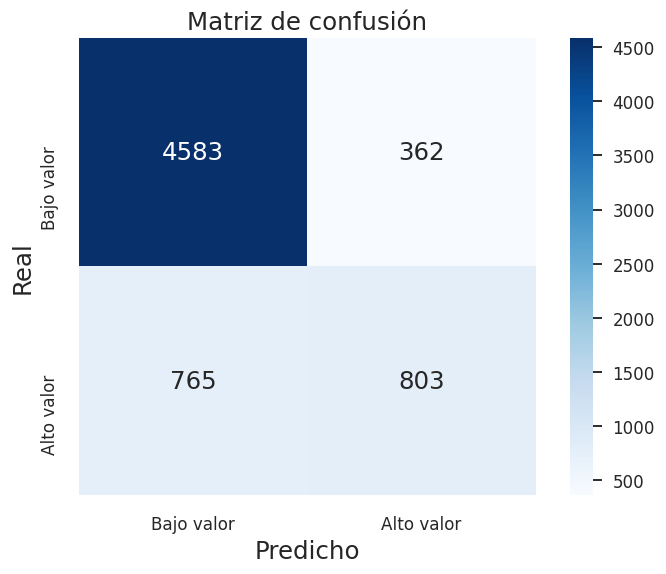

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_poly_red, y_df, test_size=0.20, random_state=10, stratify=y_df)
X_train = get_dataframe_scaled(X_train, MinMaxScaler(feature_range=(-1,1)))
X_test = get_dataframe_scaled(X_test, MinMaxScaler(feature_range=(-1,1)))

params = [ {'C':np.arange(0,30,1), 'penalty': ['l1', 'l2'], 'loss': ['hinge', 'squared_hinge']}]

clf=LinearSVC( random_state=10,verbose=True, dual=False)
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf = GridSearchCV(clf, 
                   param_grid = params,
                   scoring = 'roc_auc',
                   cv = cv_e,
                   n_jobs = -1,
                   verbose=1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)


AUC-ROC score sobre test:  0.8771938388601144


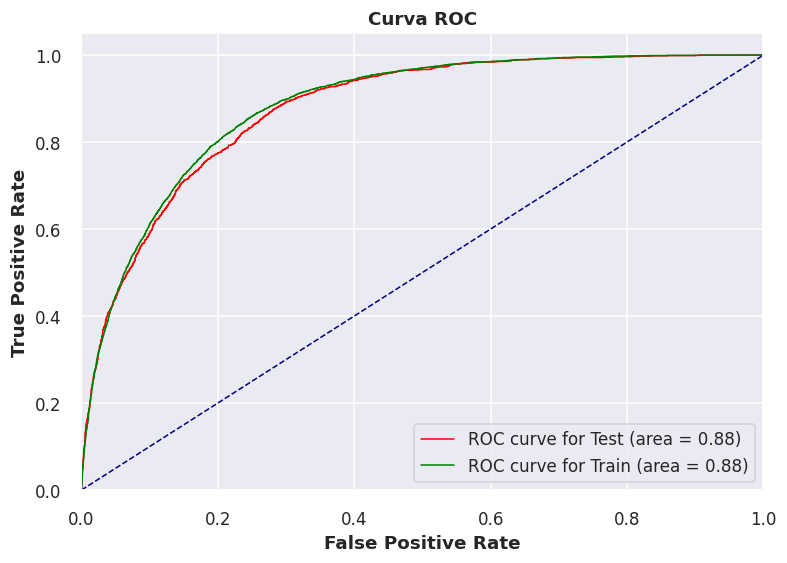

In [14]:
from sklearn.calibration import CalibratedClassifierCV

clf_best=LinearSVC(random_state=10, dual=False, C = 1, loss = 'squared_hinge', penalty ='l1')
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf_cal = CalibratedClassifierCV(clf_best,cv=cv_e) 
clf_cal.fit(X_train, y_train)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test,  clf_cal.predict_proba(X_test)[:, 1]))
plot_roc_curves(clf_cal, X_test, y_test, X_train, y_train)

## Tercer preprocesamiento: conversion_numerica_generalizada() + MinMaxScaler()

In [15]:
from preprocessing import aplicar_preparacion_generalizado
from preprocessing import conversion_numerica_generalizada

df, df_for_prediction = obtener_datasets()
X_df_2, y_df = aplicar_preparacion_generalizado(df)
X_df_numerico_2 = conversion_numerica_generalizada(X_df_2) 
X_df_numerico_2.shape

Aplicando 'conversion_numerica_generalizada' en las variables categóricas.


(32561, 43)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_df_numerico_2, y_df, test_size=0.20, random_state=10, stratify=y_df)
X_train = get_dataframe_scaled(X_train, MinMaxScaler(feature_range=(-1,1)))
X_test = get_dataframe_scaled(X_test, MinMaxScaler(feature_range=(-1,1)))

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.6min finished


[LibLinear]Accuracy sobre test:  0.8438507600184247
Los mejores hiperpametros elegidos:  {'C': 76, 'loss': 'squared_hinge', 'penalty': 'l2'}
              precision    recall  f1-score   support

  Bajo valor       0.94      0.87      0.90      5330
  Alto valor       0.55      0.73      0.63      1183

    accuracy                           0.84      6513
   macro avg       0.74      0.80      0.77      6513
weighted avg       0.87      0.84      0.85      6513



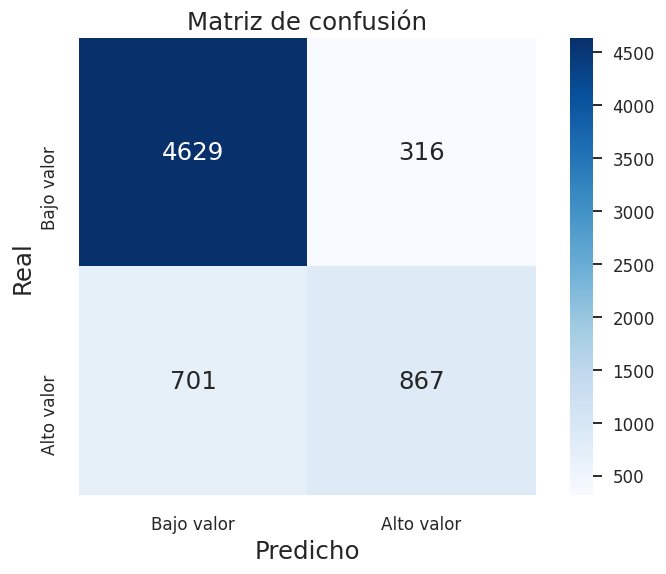

In [17]:
params = [ {'C':np.arange(60,80,1), 'penalty': ['l1', 'l2'], 'loss': ['hinge', 'squared_hinge']}]

clf=LinearSVC( random_state=10,verbose=True, dual=False)
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf = GridSearchCV(clf, 
                   param_grid = params,
                   scoring = 'roc_auc',
                   cv = cv_e,
                   n_jobs = -1,
                   verbose=1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)


AUC-ROC score sobre test:  0.8960072274612575


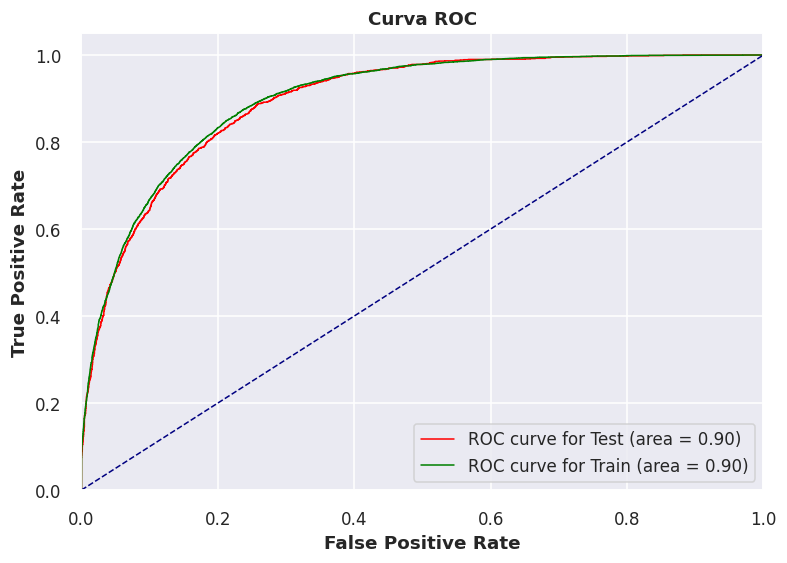

In [18]:
clf_best=LinearSVC(random_state=10, dual=False, C = 76, loss= 'squared_hinge', penalty='l2')
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf_cal = CalibratedClassifierCV(clf_best,cv=cv_e) 
clf_cal.fit(X_train, y_train)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test,  clf_cal.predict_proba(X_test)[:, 1]))
plot_roc_curves(clf_cal, X_test, y_test, X_train, y_train)

# SVC con distintos Kernels

Justificar el uso de RandomizedSearch.... el max_iter... y las limitaciones computacionales con SVC. Justificar que no es buen modelo al laburar con big data! Y éste notebook es clara su demostración.

## Primer preprocessamiento: reduccion_numerica()

Debido a tiempo computacional, limitaremos a 'max_iter' con 100. Si no hacemos esto, el algoritmo tardaria un monton en procesar. 

Aca es donde se nota la ineficiencia de SVC con distintos con la big data.

Además aplicaremos una reducción de dimensionalidad bastante profunda, conservando un ~85% de la varianza.

En el notebook de ***#0 - Análisis Exploratorio [Parte 2].ipynb*** habiamos conseguido mantener un 95% de la varianza aplicando un preprocesamietno de MinMaxScaler+TruncatedSVD con 22 componentes. Además graficámos con t-SNE con 2 componentes y logramos visualizar una buena reducción de los datos.

Ahora lo haremos simplemente con 15, manteniendo un 85%. Todo para tratar de reducir tiempo de computo.

In [19]:
df, df_for_prediction = obtener_datasets()
X_df_r, y_df_r = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df_r) 
X_df_numerico = reduccion_numerica(X_df_numerico, 0.84)
X_df_numerico.shape

Aplicando 'conversion_numerica' en las variables categóricas.
Aplicando MinMaxScaler previo al TruncatedSVD...
TruncatedSVD aplicado con 15 componentes finales se explica una varianza de: 0.8451601946


(32561, 15)

Además volvemos a aplicar otro escalado de los datos en el Split realizado, en *X_train* y *X_test* tal como nos recomienda la biblografía (https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use).


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.8min finished


[LibSVM]

/home/feduntu/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


AUC-ROC score sobre test:  0.8392321918656240
Accuracy sobre test:  0.7107323813910640
Los mejores hiperpametros elegidos:  {'kernel': 'poly', 'gamma': 0.07, 'degree': 2, 'coef0': 0.2, 'C': 1}
              precision    recall  f1-score   support

  Bajo valor       0.67      0.93      0.78      3599
  Alto valor       0.83      0.45      0.58      2914

    accuracy                           0.71      6513
   macro avg       0.75      0.69      0.68      6513
weighted avg       0.74      0.71      0.69      6513



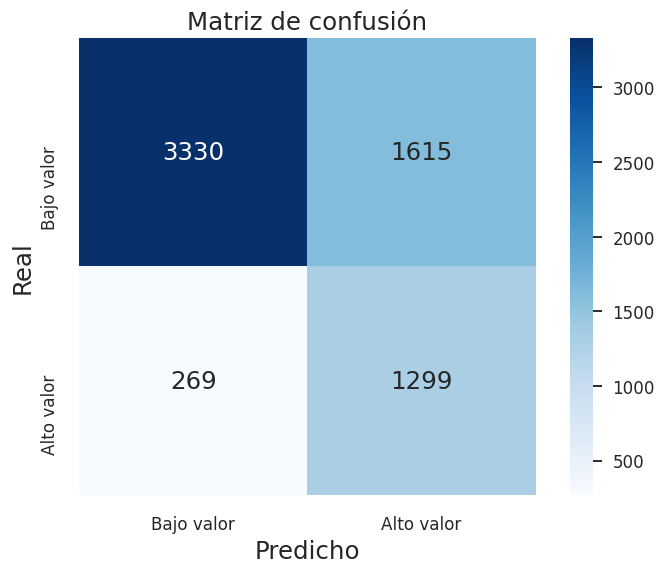

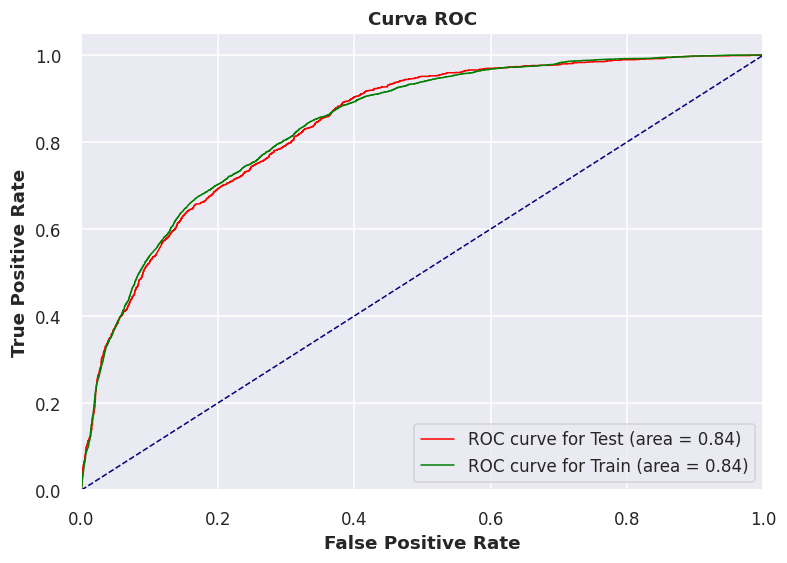

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_df_numerico, y_df_r, test_size=0.20, random_state=10, stratify=y_df_r)
X_train = get_dataframe_scaled(X_train, MinMaxScaler(feature_range=(-1,1)))
X_test = get_dataframe_scaled(X_test, MinMaxScaler(feature_range=(-1,1)))

params = [{'C':[1, 100, 300, 500, 700, 1000], 'kernel':['poly', 'rbf', 'sigmoid'], 'degree': [2,3,4] ,'gamma':[0.01,0.03,0.05, 0.07,0.09], 'coef0': [0,0.1,-0.1,0.2,-0.2]}]

clf=SVC(probability = True, random_state=10,verbose=True, cache_size = 5000, max_iter = 500)

cv_e = StratifiedKFold(n_splits=5, random_state=10, shuffle=True).split(X_train, y_train)
clf = RandomizedSearchCV(clf, params, scoring='roc_auc', cv=cv_e, n_jobs = -1, verbose=True, random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test,  clf.predict_proba(X_test)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)
#6815

## Segundo preprocesamiento: get_dataframe_polynomial() + conversion_numerica() + reduccion_numerica()

In [21]:
df, df_for_prediction = obtener_datasets()
X_df_r, y_df_r = aplicar_preparacion(df)

X_expand = get_dataframe_polynomial(X_df_r, 2, False)
X_expand.shape

Dataset inicial con 11 features...
Dataset nuevo con PolynomialFeature con 21 features...


(32561, 21)

In [22]:
X_expand_numerico = conversion_numerica(X_expand)
X_expand_numerico.shape

Aplicando 'conversion_numerica' en las variables categóricas.


(32561, 50)

In [23]:
X_expand_numerico_reducido = reduccion_numerica(X_expand_numerico, 0.85)
X_expand_numerico_reducido.shape

Aplicando MinMaxScaler previo al TruncatedSVD...
TruncatedSVD aplicado con 17 componentes finales se explica una varianza de: 0.8652603355


(32561, 17)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.2min finished


[LibSVM]

/home/feduntu/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


AUC-ROC score sobre test:  0.8404409602567012
Accuracy sobre test:  0.6734223859972363
Los mejores hiperpametros elegidos:  {'kernel': 'poly', 'gamma': 0.07, 'degree': 2, 'coef0': 0.2, 'C': 1}
              precision    recall  f1-score   support

  Bajo valor       0.60      0.95      0.74      3152
  Alto valor       0.89      0.42      0.57      3361

    accuracy                           0.67      6513
   macro avg       0.75      0.68      0.65      6513
weighted avg       0.75      0.67      0.65      6513



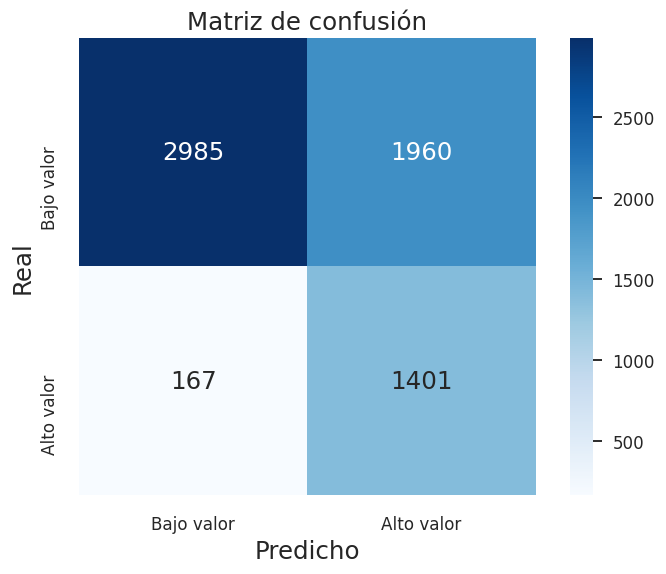

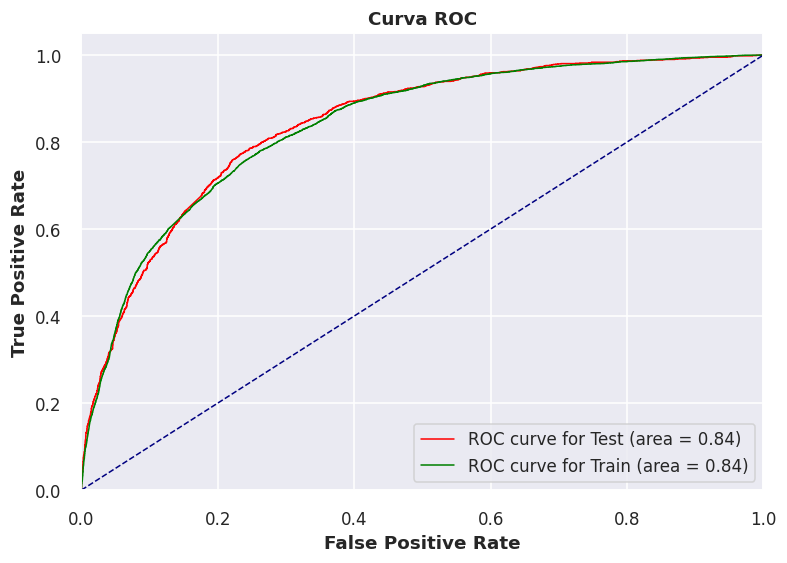

In [24]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_expand_numerico_reducido, y_df_r, test_size=0.20, random_state=10, stratify=y_df_r)
X_train = get_dataframe_scaled(X_train, MinMaxScaler(feature_range=(-1,1)))
X_test = get_dataframe_scaled(X_test, MinMaxScaler(feature_range=(-1,1)))

params = [{'C':[1, 100, 300, 500, 700, 1000], 'kernel':['poly', 'rbf', 'sigmoid'], 'degree': [2,3,4] ,'gamma':[0.01,0.03,0.05, 0.07,0.09], 'coef0': [0,0.1,-0.1,0.2,-0.2]}]

clf=SVC(probability = True, random_state=10,verbose=True, cache_size = 5000, max_iter = 500)

cv_e = StratifiedKFold(n_splits=5, random_state=10, shuffle=True).split(X_train, y_train)
clf = RandomizedSearchCV(clf, params, scoring='roc_auc', cv=cv_e, n_jobs = -1, verbose=True, random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test,  clf.predict_proba(X_test)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)
#6815